use pretrained models

https://github.com/qubvel/segmentation_models

## import

In [1]:
import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

# import cv2
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras.optimizers import SGD

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img#,save_img
from keras.callbacks import CSVLogger

D:\Anaconda2\envs\py3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from segmentation_models import Unet

In [3]:
import keras

keras.__version__

'2.1.4'

## model --pretrained resnet34

In [9]:
keras.backend.clear_session()
resnet34_model = Unet(backbone_name='resnet34', encoder_weights='imagenet', input_shape=(256, 256, 3))

In [8]:
resnet34_model.layers

In [10]:
resnet34_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn0 (Batch

zero_padding2d_9 (ZeroPadding2D (None, 66, 66, 64)   0           stage2_unit1_relu1[0][0]         
__________________________________________________________________________________________________
stage2_unit1_conv1 (Conv2D)     (None, 32, 32, 128)  73728       zero_padding2d_9[0][0]           
__________________________________________________________________________________________________
stage2_unit1_bn2 (BatchNormaliz (None, 32, 32, 128)  512         stage2_unit1_conv1[0][0]         
__________________________________________________________________________________________________
stage2_unit1_relu2 (Activation) (None, 32, 32, 128)  0           stage2_unit1_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_10 (ZeroPadding2 (None, 34, 34, 128)  0           stage2_unit1_relu2[0][0]         
__________________________________________________________________________________________________
stage2_uni

stage3_unit1_bn2 (BatchNormaliz (None, 16, 16, 256)  1024        stage3_unit1_conv1[0][0]         
__________________________________________________________________________________________________
stage3_unit1_relu2 (Activation) (None, 16, 16, 256)  0           stage3_unit1_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_18 (ZeroPadding2 (None, 18, 18, 256)  0           stage3_unit1_relu2[0][0]         
__________________________________________________________________________________________________
stage3_unit1_conv2 (Conv2D)     (None, 16, 16, 256)  589824      zero_padding2d_18[0][0]          
__________________________________________________________________________________________________
stage3_unit1_sc (Conv2D)        (None, 16, 16, 256)  32768       stage3_unit1_relu1[0][0]         
__________________________________________________________________________________________________
add_8 (Add

zero_padding2d_26 (ZeroPadding2 (None, 18, 18, 256)  0           stage3_unit5_relu2[0][0]         
__________________________________________________________________________________________________
stage3_unit5_conv2 (Conv2D)     (None, 16, 16, 256)  589824      zero_padding2d_26[0][0]          
__________________________________________________________________________________________________
add_12 (Add)                    (None, 16, 16, 256)  0           stage3_unit5_conv2[0][0]         
                                                                 add_11[0][0]                     
__________________________________________________________________________________________________
stage3_unit6_bn1 (BatchNormaliz (None, 16, 16, 256)  1024        add_12[0][0]                     
__________________________________________________________________________________________________
stage3_unit6_relu1 (Activation) (None, 16, 16, 256)  0           stage3_unit6_bn1[0][0]           
__________

add_16 (Add)                    (None, 8, 8, 512)    0           stage4_unit3_conv2[0][0]         
                                                                 add_15[0][0]                     
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 8, 8, 512)    2048        add_16[0][0]                     
__________________________________________________________________________________________________
relu1 (Activation)              (None, 8, 8, 512)    0           bn1[0][0]                        
__________________________________________________________________________________________________
decoder_stage0_upsample (UpSamp (None, 16, 16, 512)  0           relu1[0][0]                      
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 16, 16, 768)  0           decoder_stage0_upsample[0][0]    
          

In [6]:
help(resnet34_model)

Help on Model in module keras.engine.training object:

class Model(keras.engine.topology.Container)
 |  The `Model` class adds training & evaluation routines to a `Container`.
 |  
 |  Method resolution order:
 |      Model
 |      keras.engine.topology.Container
 |      keras.engine.topology.Layer
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  compile(self, optimizer, loss=None, metrics=None, loss_weights=None, sample_weight_mode=None, weighted_metrics=None, target_tensors=None, **kwargs)
 |      Configures the model for training.
 |      
 |      # Arguments
 |          optimizer: String (name of optimizer) or optimizer instance.
 |              See [optimizers](/optimizers).
 |          loss: String (name of objective function) or objective function.
 |              See [losses](/losses).
 |              If the model has multiple outputs, you can use a different loss
 |              on each output by passing a dictionary or a list of losses.
 |              The loss

## model --local 007

In [33]:
ACTIVATION = "relu"

def convolution_block(x, filters, size, strides=(1,1), padding="same", activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation:
        x = Activation(ACTIVATION)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = Activation(ACTIVATION)(blockInput)
    x = BatchNormalization()(x)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

# Build model
def _build_model(input_layer, start_neurons, DropoutRatio = 0.5, padding="same"):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding=padding)(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = Activation(ACTIVATION)(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding=padding)(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = Activation(ACTIVATION)(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding=padding)(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = Activation(ACTIVATION)(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding=padding)(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = Activation(ACTIVATION)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding=padding)(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16)
    convm = Activation(ACTIVATION)(convm)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding=padding)(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding=padding)(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = Activation(ACTIVATION)(uconv4)
    
    # 12 -> 25
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding=padding)(uconv4)
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding=padding)(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = Activation(ACTIVATION)(uconv3)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding=padding)(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding=padding)(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = Activation(ACTIVATION)(uconv2)
    
    # 50 -> 101
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding=padding)(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding=padding)(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = Activation(ACTIVATION)(uconv1)
    
    uconv1 = Dropout(DropoutRatio/2)(uconv1)
    output_layer = Conv2D(1, (1,1), padding=padding, activation="sigmoid")(uconv1)
    
    return output_layer


def build_007model(img_size_target):
    input_layer = Input((img_size_target, img_size_target, 1))
    output_layer = _build_model(input_layer, 32, 0.5, "same")

    model = Model(input_layer, output_layer)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])
    return model

In [34]:
local007_model = build_007model(101)

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concat axis. Got inputs shapes: [(None, 100, 100, 32), (None, 101, 101, 32)]

In [29]:
local007_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
conv2d_148 (Conv2D)             (None, 101, 101, 32) 320         input_6[0][0]                    
__________________________________________________________________________________________________
activation_146 (Activation)     (None, 101, 101, 32) 0           conv2d_148[0][0]                 
__________________________________________________________________________________________________
batch_normalization_175 (BatchN (None, 101, 101, 32) 128         activation_146[0][0]             
__________________________________________________________________________________________________
conv2d_149

__________________________________________________________________________________________________
activation_155 (Activation)     (None, 50, 50, 64)   0           add_78[0][0]                     
__________________________________________________________________________________________________
max_pooling2d_18 (MaxPooling2D) (None, 25, 25, 64)   0           activation_155[0][0]             
__________________________________________________________________________________________________
dropout_29 (Dropout)            (None, 25, 25, 64)   0           max_pooling2d_18[0][0]           
__________________________________________________________________________________________________
conv2d_158 (Conv2D)             (None, 25, 25, 128)  73856       dropout_29[0][0]                 
__________________________________________________________________________________________________
activation_156 (Activation)     (None, 25, 25, 128)  0           conv2d_158[0][0]                 
__________

add_82 (Add)                    (None, 12, 12, 256)  0           batch_normalization_198[0][0]    
                                                                 add_81[0][0]                     
__________________________________________________________________________________________________
activation_165 (Activation)     (None, 12, 12, 256)  0           add_82[0][0]                     
__________________________________________________________________________________________________
max_pooling2d_20 (MaxPooling2D) (None, 6, 6, 256)    0           activation_165[0][0]             
__________________________________________________________________________________________________
dropout_31 (Dropout)            (None, 6, 6, 256)    0           max_pooling2d_20[0][0]           
__________________________________________________________________________________________________
conv2d_168 (Conv2D)             (None, 6, 6, 512)    1180160     dropout_31[0][0]                 
__________

__________________________________________________________________________________________________
conv2d_177 (Conv2D)             (None, 12, 12, 256)  590080      activation_174[0][0]             
__________________________________________________________________________________________________
batch_normalization_210 (BatchN (None, 12, 12, 256)  1024        conv2d_177[0][0]                 
__________________________________________________________________________________________________
add_86 (Add)                    (None, 12, 12, 256)  0           batch_normalization_210[0][0]    
                                                                 add_85[0][0]                     
__________________________________________________________________________________________________
activation_175 (Activation)     (None, 12, 12, 256)  0           add_86[0][0]                     
__________________________________________________________________________________________________
conv2d_tra

__________________________________________________________________________________________________
batch_normalization_220 (BatchN (None, 50, 50, 64)   256         activation_183[0][0]             
__________________________________________________________________________________________________
conv2d_186 (Conv2D)             (None, 50, 50, 64)   36928       batch_normalization_220[0][0]    
__________________________________________________________________________________________________
batch_normalization_221 (BatchN (None, 50, 50, 64)   256         conv2d_186[0][0]                 
__________________________________________________________________________________________________
activation_184 (Activation)     (None, 50, 50, 64)   0           batch_normalization_221[0][0]    
__________________________________________________________________________________________________
conv2d_187 (Conv2D)             (None, 50, 50, 64)   36928       activation_184[0][0]             
__________

In [7]:
keras.backend.clear_session()

In [6]:
keras.backend.clear_session()
model = Unet(backbone_name='resnet50', encoder_weights='imagenet')

A local file was found, but it seems to be incomplete or outdated because the md5 file hash does not match the original value of db3b217156506944570ac220086f09b6 so we will re-download the data.
94593024/94592056 [==============================] - ETA: 1:42:0 - ETA: 51:19  - ETA: 41:1 - ETA: 28:3 - ETA: 23:4 - ETA: 16:0 - ETA: 16:2 - ETA: 13:3 - ETA: 13:4 - ETA: 12:3 - ETA: 10:3 - ETA: 10:5 - ETA: 8:4 - ETA: 9: - ETA: 7: - ETA: 7: - ETA: 6: - ETA: 5: - ETA: 5: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 1: - ETA: 48s - ETA: 47 - ETA: 46 - ETA: 45 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 43 - ETA: 42 - ETA: 41 - ETA: 41 - ETA: 40 - ETA: 40 - ETA: 39 - ETA: 38 - ETA: 38 - ETA: 37 - ETA: 37 - ETA: 36 - ETA: 36 - ETA: 36 - E

## train --fold 0

In [24]:
exp_code = "009"

for i, (train_idx, valid_idx) in enumerate(kfold_index):
    print("fold:", i)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    model_filepath = "{}-model-resnet-fold-{}.hdf5".format(exp_code, i)
    log_filepath = "{}-log-resnet-fold-{}.csv".format(exp_code, i)
    
    print("mode:", model_filepath)
    print("log:", log_filepath)

    early_stopping = EarlyStopping(monitor='val_acc', mode = 'max',patience=20, verbose=1)
    model_checkpoint = ModelCheckpoint(model_filepath, monitor='val_acc', mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_acc', mode = 'max', factor=0.2, patience=5, min_lr=0.00001, verbose=1)
    model_logger = CSVLogger(log_filepath, separator=',', append=False)

    epochs = 200
    batch_size = 16
    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    # optimizer = SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)
    # model.fit(X_train, Y_train,
    #           validation_data=[X_valid, Y_valid], 
    #           epochs=epochs,
    #           batch_size=batch_size,
    #           callbacks=[early_stopping, model_checkpoint, reduce_lr, model_logger], 
    #           verbose=200)
    
    # break

    def train():
        model = Unet(backbone_name='resnet50', encoder_weights='imagenet')
        model.compile("adam", 'binary_crossentropy', ['acc'])
        print("load model done.")

        model.fit_generator(generate_batch_data_random(X_train, Y_train, batch_size),
                            validation_data=generate_batch_data(X_valid, Y_valid, 50), 
                            epochs=epochs,
                            steps_per_epoch=100,
                            callbacks=[early_stopping, model_checkpoint, reduce_lr, model_logger],
                            validation_steps=16,
                            verbose=200)
        keras.backend.clear_session()
        
    %time train()
    break

fold: 0
index.shape: (3196,) (804,)
mode: 009-model-resnet-fold-0.hdf5
log: 009-log-resnet-fold-0.csv
load model done.
Epoch 1/200


D:\Anaconda2\envs\py3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "



Epoch 00001: val_acc improved from -inf to 0.90036, saving model to 009-model-resnet-fold-0.hdf5
Epoch 2/200

Epoch 00002: val_acc improved from 0.90036 to 0.90884, saving model to 009-model-resnet-fold-0.hdf5
Epoch 3/200

Epoch 00003: val_acc improved from 0.90884 to 0.93270, saving model to 009-model-resnet-fold-0.hdf5
Epoch 4/200

Epoch 00004: val_acc did not improve
Epoch 5/200

Epoch 00005: val_acc did not improve
Epoch 6/200

Epoch 00006: val_acc did not improve
Epoch 7/200

Epoch 00007: val_acc did not improve
Epoch 8/200

Epoch 00008: val_acc did not improve
Epoch 9/200

Epoch 00009: val_acc did not improve

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 10/200

Epoch 00010: val_acc did not improve
Epoch 11/200

Epoch 00011: val_acc improved from 0.93270 to 0.93446, saving model to 009-model-resnet-fold-0.hdf5
Epoch 12/200

Epoch 00012: val_acc improved from 0.93446 to 0.93620, saving model to 009-model-resnet-fold-0.hdf5
Epoch 13/200

E

In [88]:
exp_code = "009"

for i, (train_idx, valid_idx) in enumerate(kfold_index):
    print("fold:", i)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    model_filepath = "{}-model-resnet-fold-{}.hdf5".format(exp_code, i)
    log_filepath = "{}-log-resnet-fold-{}.csv".format(exp_code, i)
    
    print("mode:", model_filepath)
    print("log:", log_filepath)

    early_stopping = EarlyStopping(monitor='val_acc', mode = 'max',patience=20, verbose=1)
    model_checkpoint = ModelCheckpoint(model_filepath, monitor='val_acc', mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_acc', mode = 'max', factor=0.2, patience=5, min_lr=0.00001, verbose=1)
    model_logger = CSVLogger(log_filepath, separator=',', append=False)

    epochs = 200
    batch_size = 32
    
    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    
    X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
    Y_train = np.append(Y_train, [np.fliplr(x) for x in Y_train], axis=0)
    
    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    
    model = build_model(img_size_target=101)
    print("build model.")
    
    def train():

        return model.fit(X_train, Y_train,
                         validation_data=[X_valid, Y_valid], 
                         epochs=epochs,
                         batch_size=batch_size,
                         callbacks=[early_stopping, model_checkpoint, reduce_lr, model_logger], 
                         verbose=200)
    
    %time train()

fold: 0
index.shape: (3196,) (804,)
mode: 007-model-resnet-fold-0.hdf5
log: 007-log-resnet-fold-0.csv
data.shape: (6392, 101, 101, 1) (6392, 101, 101, 1) (804, 101, 101, 1) (804, 101, 101, 1)
build model.
Train on 6392 samples, validate on 804 samples
Epoch 1/200
Epoch 00001: val_acc improved from -inf to 0.24839, saving model to 007-model-resnet-fold-0.hdf5
Epoch 2/200
Epoch 00002: val_acc improved from 0.24839 to 0.65560, saving model to 007-model-resnet-fold-0.hdf5
Epoch 3/200
Epoch 00003: val_acc improved from 0.65560 to 0.89232, saving model to 007-model-resnet-fold-0.hdf5
Epoch 4/200
Epoch 00004: val_acc improved from 0.89232 to 0.90095, saving model to 007-model-resnet-fold-0.hdf5
Epoch 5/200
Epoch 00005: val_acc improved from 0.90095 to 0.91183, saving model to 007-model-resnet-fold-0.hdf5
Epoch 6/200
Epoch 00006: val_acc improved from 0.91183 to 0.91594, saving model to 007-model-resnet-fold-0.hdf5
Epoch 7/200
Epoch 00007: val_acc did not improve
Epoch 8/200
Epoch 00008: val_a

Epoch 00010: val_acc improved from 0.92795 to 0.93912, saving model to 007-model-resnet-fold-4.hdf5
Epoch 11/200
Epoch 00011: val_acc did not improve
Epoch 12/200
Epoch 00012: val_acc did not improve
Epoch 13/200
Epoch 00013: val_acc did not improve
Epoch 14/200
Epoch 00014: val_acc did not improve
Epoch 15/200
Epoch 00015: val_acc improved from 0.93912 to 0.94232, saving model to 007-model-resnet-fold-4.hdf5
Epoch 16/200
Epoch 00016: val_acc did not improve
Epoch 17/200
Epoch 00017: val_acc improved from 0.94232 to 0.94579, saving model to 007-model-resnet-fold-4.hdf5
Epoch 18/200
Epoch 00018: val_acc did not improve
Epoch 19/200
Epoch 00019: val_acc did not improve
Epoch 20/200
Epoch 00020: val_acc did not improve
Epoch 21/200
Epoch 00021: val_acc did not improve
Epoch 22/200
Epoch 00022: val_acc did not improve
Epoch 23/200
Epoch 00023: val_acc did not improve

Epoch 00023: reducing learning rate to 0.00020000000949949026.
Epoch 24/200
Epoch 00024: val_acc improved from 0.94579 to 0

## search threshold

In [98]:
def predict_result(model, x_test, img_size_target): # predict both orginal and reflect x
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(a) for a in model.predict(np.array([np.fliplr(x) for x in x_test])).reshape(-1, img_size_target, img_size_target)])
    return preds_test / 2.0

def filter_image(img):
    if img.sum() < 100:
        return np.zeros(img.shape)
    else:
        return img

import glob
glob.glob("./007*.hdf5")

['.\\007-model-resnet-fold-0.hdf5',
 '.\\007-model-resnet-fold-1.hdf5',
 '.\\007-model-resnet-fold-2.hdf5',
 '.\\007-model-resnet-fold-3.hdf5',
 '.\\007-model-resnet-fold-4.hdf5']

In [100]:
thresholds = np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])

def iou(img_true, img_pred):
    i = np.sum((img_true*img_pred) >0)
    u = np.sum((img_true + img_pred) >0)
    if u == 0:
        return u
    return i/u

def iou_metric(imgs_true, imgs_pred):
    num_images = len(imgs_true)
    scores = np.zeros(num_images)
    
    for i in range(num_images):
        if imgs_true[i].sum() == imgs_pred[i].sum() == 0:
            scores[i] = 1
        else:
            scores[i] = (thresholds <= iou(imgs_true[i], imgs_pred[i])).mean()
            
    return scores.mean()

(3196,) (804,)
.\007-model-resnet-fold-0.hdf5


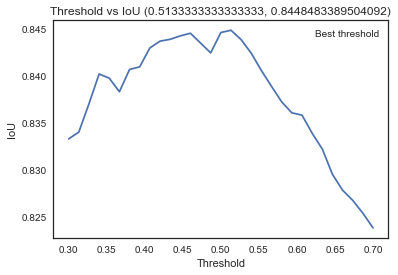

(3199,) (801,)
.\007-model-resnet-fold-1.hdf5


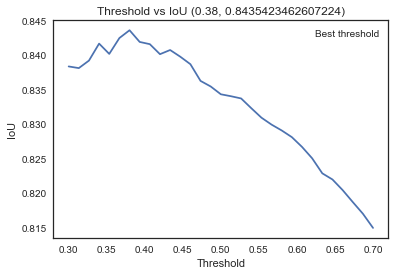

(3200,) (800,)
.\007-model-resnet-fold-2.hdf5


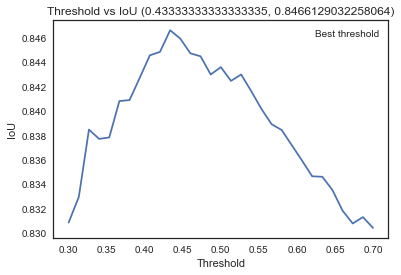

(3201,) (799,)
.\007-model-resnet-fold-3.hdf5


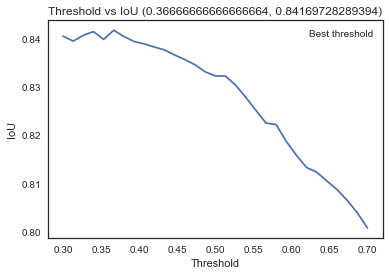

(3204,) (796,)
.\007-model-resnet-fold-4.hdf5


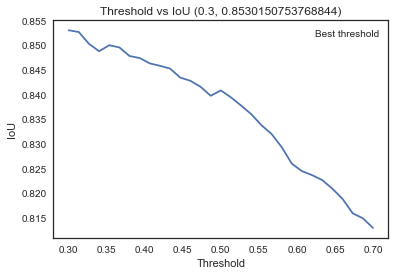

0.8459431893415525 0.0038845992128691514


In [102]:
model_filepaths = [
    '.\\007-model-resnet-fold-0.hdf5',
    '.\\007-model-resnet-fold-1.hdf5',
    '.\\007-model-resnet-fold-2.hdf5',
    '.\\007-model-resnet-fold-3.hdf5',
    '.\\007-model-resnet-fold-4.hdf5'
]

threshold_best_stack = []
iou_best_stack = []

for (train_idx, valid_idx), model_filepath in zip(kfold_index, model_filepaths):
    print(train_idx.shape, valid_idx.shape)
    print(model_filepath)
    
    ## preds_valid
    X_valid = X[valid_idx, :]
    Y_valid = Y[valid_idx, :]
    
    model = load_model(model_filepath)
    preds_valid = predict_result(model, X_valid, img_size_target)
    
    ## Scoring for last model
    thresholds = np.linspace(0.3, 0.7, 31)
    ious = np.array([iou_metric(Y_valid.reshape((-1, img_size_target, img_size_target)), [filter_image(img) for img in preds_valid > threshold]) for threshold in tqdm_notebook(thresholds)])
    
    threshold_best_index = np.argmax(ious) 
    iou_best = ious[threshold_best_index]
    threshold_best = thresholds[threshold_best_index]
    
    threshold_best_stack.append(threshold_best)
    iou_best_stack.append(iou_best)

    plt.plot(thresholds, ious)
    plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
    plt.xlabel("Threshold")
    plt.ylabel("IoU")
    plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
    plt.legend()
    plt.show()
    
print(np.mean(iou_best_stack), np.std(iou_best_stack))

## predict test

threshold_best_stack = [0.5133333333333333, 0.38, 0.43333333333333335, 0.36666666666666664, 0.3]

In [2]:
img_size_target = 101

In [3]:
def predict_result(model, x_test, img_size_target): # predict both orginal and reflect x
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(a) for a in model.predict(np.array([np.fliplr(x) for x in x_test])).reshape(-1, img_size_target, img_size_target)])
    return preds_test / 2.0

def filter_image(img):
    if img.sum() < 100:
        return np.zeros(img.shape)
    else:
        return img

model_filepaths = [
    '.\\007-model-resnet-fold-0.hdf5',
    '.\\007-model-resnet-fold-1.hdf5',
    '.\\007-model-resnet-fold-2.hdf5',
    '.\\007-model-resnet-fold-3.hdf5',
    '.\\007-model-resnet-fold-4.hdf5'
]

threshold_best_stack = [0.5133333333333333, 0.38, 0.43333333333333335, 0.36666666666666664, 0.3]

In [4]:
# Loading of training/testing ids and depths

train_df = pd.read_csv("./data/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("./data/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

4000

In [5]:
x_test = np.array([(np.array(load_img("./data/test/images/{}.png".format(idx), grayscale = True))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

In [6]:
preds_test = np.zeros((18000,101,101))
preds_test.shape

(18000, 101, 101)

In [7]:
# bld
for model_filepath, threshold_best in zip(model_filepaths, threshold_best_stack):
    print(model_filepath, threshold_best)
    model = load_model(model_filepath)
    pred_temp = predict_result(model, x_test, img_size_target)
    print(pred_temp.shape, preds_test.shape)
    preds_test += pred_temp
    
preds_test = preds_test > sum(threshold_best_stack)

.\007-model-resnet-fold-0.hdf5 0.5133333333333333
(18000, 101, 101) (18000, 101, 101)
.\007-model-resnet-fold-1.hdf5 0.38
(18000, 101, 101) (18000, 101, 101)
.\007-model-resnet-fold-2.hdf5 0.43333333333333335
(18000, 101, 101) (18000, 101, 101)
.\007-model-resnet-fold-3.hdf5 0.36666666666666664
(18000, 101, 101) (18000, 101, 101)
.\007-model-resnet-fold-4.hdf5 0.3
(18000, 101, 101) (18000, 101, 101)


In [11]:
# vote
for model_filepath, threshold_best in zip(model_filepaths, threshold_best_stack):
    print(model_filepath, threshold_best)
    model = load_model(model_filepath)
    pred_temp = (predict_result(model, x_test, img_size_target) > threshold_best)
    print(pred_temp.shape, preds_test.shape)
    preds_test += pred_temp
    
preds_test = preds_test >= 3

.\007-model-resnet-fold-0.hdf5 0.5133333333333333
(18000, 101, 101) (18000, 101, 101)
.\007-model-resnet-fold-1.hdf5 0.38
(18000, 101, 101) (18000, 101, 101)
.\007-model-resnet-fold-2.hdf5 0.43333333333333335
(18000, 101, 101) (18000, 101, 101)
.\007-model-resnet-fold-3.hdf5 0.36666666666666664
(18000, 101, 101) (18000, 101, 101)
.\007-model-resnet-fold-4.hdf5 0.3
(18000, 101, 101) (18000, 101, 101)


In [9]:
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_encode2(im):
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [10]:
import time
t1 = time.time()
pred_dict = {idx: rle_encode2(filter_image(preds_test[i])) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()

print(f"Usedtime = {t2-t1} s")

Usedtime = 8.09692645072937 s


In [11]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('./result/007-submission-bld.csv')

In [12]:
sub.head(10)

,rle_mask
id,
353e010b7b,
5439dbbddf,
71bab9f311,
52551f7a80,
512d8d9997,3 1 102 1 104 1 203 5 304 3 405 6 506 3 510 1 ...
64dba827d6,
0a3a8a5f37,
329563756f,1 4948 4950 100 5051 99 5152 98 5253 97 5354 9...
f6cba2e890,


In [18]:
sub.head(10)

,rle_mask
id,
353e010b7b,
5439dbbddf,
71bab9f311,
52551f7a80,
512d8d9997,94 8 194 9 296 8 396 9 495 11 595 12 696 12 79...
64dba827d6,
0a3a8a5f37,
329563756f,1 9077 9084 91 9189 83 9293 76 9394 71 9495 66...
f6cba2e890,
